# Forecast using Multi Layer DNN 

This notebook covers how to create a multiple layer dense neural net to forecast a time series

- Creation of a windowed dataset 
- Split features and labels 
- Create a model with multiple Dense layers 
- Evaluate performance

In [132]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [133]:
# Let's install tensorflow 2.x first :)
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [134]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [135]:
def plot_series(time, series, format="-", start=0, end=None):
    '''
    Plot series of data

    Parameters
    ----------
    time : array of data
    series: array of data to plot in Y axis 
    format: format of basic line properties. Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
    start: from where to start plotting, optional. Default: 0
    end: up to where to plot data, optional. Default: None
    '''
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [136]:
def trend(time, slope=0):
    '''
    Produce a trend of data.
    Parameters
    ---------- 
    time: time series to plot 
    slope: slope to plot the series. optional, Default: 0
    '''
    return slope * time

In [137]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern by using np.where
    Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
    
    Parameters
    ----------
    season_time: to generate the condition of what to select from 
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [138]:
def seasonality(time, period, amplitude=1, phase=0):
    '''
    Repeats the same pattern at each period
    
    Parameters
    ----------
    time: to generate the season over x axis 
    period: how often will repeat
    amplitude: how many phases 
    phase: the position of the point in time
    '''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [139]:
def noise(time, noise_level=1, seed=None):
    '''
    Produce random noise into a time series 

    Parameters
    ----------
    time: series of values on X axis
    noise_level: to be produced, optional. Default: 1
    seed: seed to generate the noise, optional. Default: None 
    '''
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [140]:
# Define initial time series
time = np.arange(4 * 365 + 1, dtype="float32") 

In [141]:
# Define initial values for generation of different time series 
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [142]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

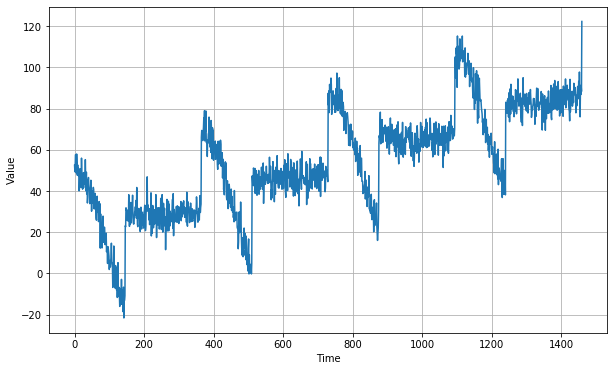

In [143]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [144]:
# Split into training and validation
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [145]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [146]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Creates a windowed dataset and returns only one from the batch 
    
    Parameters
    ----------
    series: time series data to set as dataset
    windows_size: size of the window to be created
    batch_size: size of the batch by window 
    shuffle_buffer: buffer size to take data and shuffle it around
    
    Returns a transformed dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [147]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [148]:
# Create a model with 3 Layers layer Created
# Using relu activation and last layer ouput: 1 value
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [149]:
'''
Configure the model with: 
- Loss: mean squared error 
- Optimizer: Stochastic Gradient Descent 
'''
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [150]:
# Train the model for 100 epochs
model.fit(dataset,epochs=100,verbose=0)

In [151]:
# Create a moving average time series with the prediction created by the model
forecast = []
range_values = len(series) - window_size

In [152]:
for time in range(range_values):
    # Add the prediction to the forecast array 
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [153]:
forecast = forecast[split_time-window_size:]

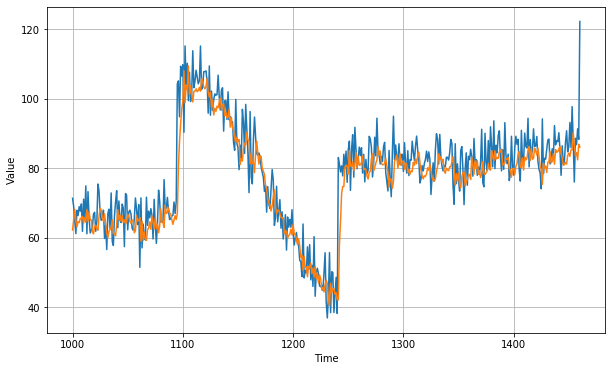

In [154]:
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [155]:
# Get the MAE metric
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.077003

# Tuning the learning rate of the optimizer 

Tensorflow offers a way to tune the learning rate on each epoch if need it by using the [Learning Rate Scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)

This is injected on the callbacks namespace and will be set on the callbacks parameter on the fit method related to the model

In [156]:
initial_lr = 1e-10

In [157]:
# Define learning rate scheduler 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: initial_lr * 10**(epoch / 20))

In [158]:
optimizer = tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)

In [159]:
model.compile(loss="mse", optimizer=optimizer)

In [160]:
history_a = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-10, 0.001, 0, 100]

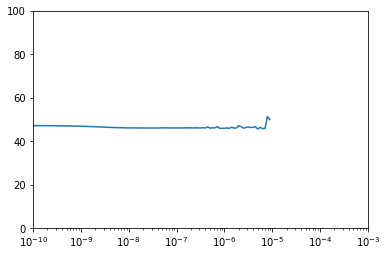

In [162]:
# Plot the learning rates across training 
lrs = initial_lr * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history_a.history["loss"])
plt.axis([initial_lr, 1e-3, 0, 100])

In [163]:
print(min(history_a.history["loss"]))


45.50991349512217


In [165]:
min_loss = history_a.history["loss"].index(45.50991349512217)
print("Minimum loss at learning rate {}".format(lrs[min_loss]))

Minimum loss at learning rate 3.1622776601683797e-07


In [166]:
tuned_learning_rate = 3e-7

## Adjust the learning rate 
After finding the right value for Learning Rate, train again with the new value amnd check the performance metrics

In [167]:
window_size = 30

In [168]:
# Create a new windowed dataset
new_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [169]:
# Create a model with 3 layers 
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [170]:
# Create the optimizer with the new learning rate after tuning 
optimizer = tf.keras.optimizers.SGD(lr=tuned_learning_rate, momentum=0.9)

In [171]:
# Configure the model with MSE loss and SGD optimizer
model.compile(loss="mse", optimizer=optimizer)

In [172]:
# Train the model for 500 epochs
history = model.fit(new_dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 12ms/step - loss: 604.2860
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 149.7525
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 116.8868
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 109.6739
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 105.9975
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 99.5968
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 95.9627
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 92.6722
Epoch 9/500
31/31 [==============================] - 0s 4ms/step - loss: 88.9734
Epoch 10/500
31/31 [==============================] - 0s 4ms/step - loss: 86.6210
Epoch 11/500
31/31 [==============================] - 0s 4ms/step - loss: 83.8826
Epoch 12/500
31/31 [==============================] - 0s 4ms/step - loss: 82.3499
Epoch 13/500
31/31 

31/31 [==============================] - 0s 4ms/step - loss: 49.8908
Epoch 101/500
31/31 [==============================] - 0s 4ms/step - loss: 50.4237
Epoch 102/500
31/31 [==============================] - 0s 4ms/step - loss: 49.8666
Epoch 103/500
31/31 [==============================] - 0s 4ms/step - loss: 50.3802
Epoch 104/500
31/31 [==============================] - 0s 4ms/step - loss: 49.6084
Epoch 105/500
31/31 [==============================] - 0s 4ms/step - loss: 49.5439
Epoch 106/500
31/31 [==============================] - 0s 4ms/step - loss: 49.8258
Epoch 107/500
31/31 [==============================] - 0s 4ms/step - loss: 49.9640
Epoch 108/500
31/31 [==============================] - 0s 4ms/step - loss: 49.9769
Epoch 109/500
31/31 [==============================] - 0s 4ms/step - loss: 49.1385
Epoch 110/500
31/31 [==============================] - 0s 4ms/step - loss: 49.9734
Epoch 111/500
31/31 [==============================] - 0s 4ms/step - loss: 49.4943
Epoch 112/500
31/3

31/31 [==============================] - 0s 4ms/step - loss: 45.0206
Epoch 199/500
31/31 [==============================] - 0s 4ms/step - loss: 45.3015
Epoch 200/500
31/31 [==============================] - 0s 4ms/step - loss: 45.4812
Epoch 201/500
31/31 [==============================] - 0s 4ms/step - loss: 45.9250
Epoch 202/500
31/31 [==============================] - 0s 4ms/step - loss: 45.4835
Epoch 203/500
31/31 [==============================] - 0s 4ms/step - loss: 45.2927
Epoch 204/500
31/31 [==============================] - 0s 4ms/step - loss: 45.9988
Epoch 205/500
31/31 [==============================] - 0s 4ms/step - loss: 44.9663
Epoch 206/500
31/31 [==============================] - 0s 4ms/step - loss: 45.3095
Epoch 207/500
31/31 [==============================] - 0s 4ms/step - loss: 45.4540
Epoch 208/500
31/31 [==============================] - 0s 4ms/step - loss: 44.9983
Epoch 209/500
31/31 [==============================] - 0s 4ms/step - loss: 44.8389
Epoch 210/500
31/3

31/31 [==============================] - 0s 4ms/step - loss: 43.6996
Epoch 297/500
31/31 [==============================] - 0s 4ms/step - loss: 43.8757
Epoch 298/500
31/31 [==============================] - 0s 4ms/step - loss: 43.2563
Epoch 299/500
31/31 [==============================] - 0s 4ms/step - loss: 43.4324
Epoch 300/500
31/31 [==============================] - 0s 4ms/step - loss: 43.2344
Epoch 301/500
31/31 [==============================] - 0s 4ms/step - loss: 43.4001
Epoch 302/500
31/31 [==============================] - 0s 4ms/step - loss: 43.1677
Epoch 303/500
31/31 [==============================] - 0s 4ms/step - loss: 43.3255
Epoch 304/500
31/31 [==============================] - 0s 4ms/step - loss: 43.1864
Epoch 305/500
31/31 [==============================] - 0s 4ms/step - loss: 43.1931
Epoch 306/500
31/31 [==============================] - 0s 4ms/step - loss: 43.1357
Epoch 307/500
31/31 [==============================] - 0s 4ms/step - loss: 42.6822
Epoch 308/500
31/3

31/31 [==============================] - 0s 4ms/step - loss: 42.0820
Epoch 395/500
31/31 [==============================] - 0s 4ms/step - loss: 42.1349
Epoch 396/500
31/31 [==============================] - 0s 4ms/step - loss: 41.8622
Epoch 397/500
31/31 [==============================] - 0s 4ms/step - loss: 42.3105
Epoch 398/500
31/31 [==============================] - 0s 4ms/step - loss: 41.5607
Epoch 399/500
31/31 [==============================] - 0s 4ms/step - loss: 40.2672
Epoch 400/500
31/31 [==============================] - 0s 4ms/step - loss: 41.8317
Epoch 401/500
31/31 [==============================] - 0s 4ms/step - loss: 42.0196
Epoch 402/500
31/31 [==============================] - 0s 4ms/step - loss: 42.3270
Epoch 403/500
31/31 [==============================] - 0s 4ms/step - loss: 42.1487
Epoch 404/500
31/31 [==============================] - 0s 4ms/step - loss: 40.5888
Epoch 405/500
31/31 [==============================] - 0s 4ms/step - loss: 42.0993
Epoch 406/500
31/3

31/31 [==============================] - 0s 4ms/step - loss: 41.1529
Epoch 493/500
31/31 [==============================] - 0s 4ms/step - loss: 40.9851
Epoch 494/500
31/31 [==============================] - 0s 4ms/step - loss: 41.0949
Epoch 495/500
31/31 [==============================] - 0s 4ms/step - loss: 40.9483
Epoch 496/500
31/31 [==============================] - 0s 4ms/step - loss: 39.7403
Epoch 497/500
31/31 [==============================] - 0s 4ms/step - loss: 41.1377
Epoch 498/500
31/31 [==============================] - 0s 4ms/step - loss: 41.2878
Epoch 499/500
31/31 [==============================] - 0s 4ms/step - loss: 41.0751
Epoch 500/500
31/31 [==============================] - 0s 4ms/step - loss: 41.0310


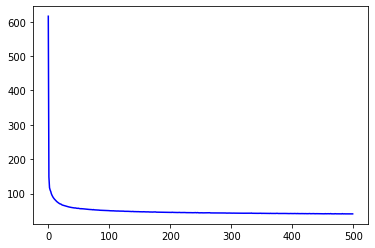

In [173]:
# Plot the losss 
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

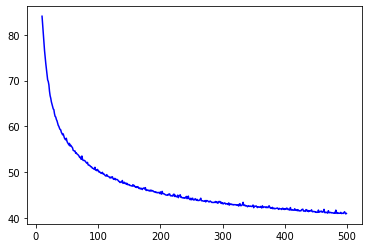

In [174]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [179]:
forecast_tuned = []
for time in range(len(series) - window_size):
    forecast_tuned.append(model.predict(series[time:time + window_size][np.newaxis]))

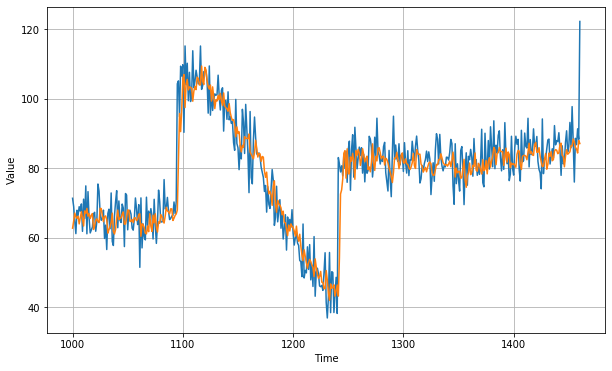

In [180]:
forecast_tuned = forecast_tuned[split_time-window_size:]
results = np.array(forecast_tuned)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [181]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7980385